# Initial imports and declarations
Will be expanded later to include a bevy of imports for various processing, data exploration, and modelling.

In [1]:
                                #core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#post-modelling metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
df = pd.read_csv("protests.csv")

---
# Data Structures 
Includes function declarations, lists, dictionaries, etc. that are used later in the program.

In [3]:
response_drops = [
    '1_accomodation', '1_arrests', '1_beatings', '1_crowd dispersal', '1_ignore', '1_killings', '1_shootings',
    '2_accomodation', '2_arrests', '2_beatings', '2_crowd dispersal', '2_ignore', '2_killings', '2_shootings', 
    '3_accomodation', '3_arrests', '3_beatings', '3_crowd dispersal', '3_ignore', '3_killings', '3_shootings', 
    '4_accomodation', '4_arrests', '4_beatings', '4_crowd dispersal', '4_killings', '4_shootings', 
    '5_.', '5_accomodation', '5_arrests', '5_beatings', '5_crowd dispersal', '5_killings', '5_shootings', 
    '6_accomodation', '6_arrests', '6_beatings', '6_crowd dispersal', '6_killings', 
    '7_.', '7_accomodation', '7_arrests', '7_beatings', '7_killings'
]

demand_drops = [
    'demand1_labor wage dispute', 'demand1_land farm issue', 'demand1_police brutality', 'demand1_political behavior, process', 'demand1_price increases, tax policy', 'demand1_removal of politician', 'demand1_social restrictions', 
    'demand2_labor wage dispute', 'demand2_land farm issue', 'demand2_police brutality', 'demand2_political behavior, process', 'demand2_price increases, tax policy', 'demand2_removal of politician', 'demand2_social restrictions', 
    'demand3_labor wage dispute', 'demand3_land farm issue', 'demand3_police brutality', 'demand3_political behavior, process', 'demand3_price increases, tax policy', 'demand3_removal of politician', 'demand3_social restrictions', 
    'demand4_.', 'demand4_labor wage dispute', 'demand4_land farm issue', 'demand4_police brutality', 'demand4_political behavior, process', 'demand4_price increases, tax policy', 'demand4_removal of politician'
]

time_drops = ['startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear']

other_drops = [
    'id', #Not useful to prediction.
    'ccode', #Not useful to prediction.
    'protest', #All values are 1.  Is this dataset the subset of another?
    'protestnumber', # of protests per country might be useful but not in the context of incremental numbers that it's being given
    'location', #Not extremely useable given how it's already being broken by region.
    'participants_category', #Too many null values to be of great value.
]

demands = ['protesterdemand1', 'protesterdemand2', 'protesterdemand3', 'protesterdemand4']

response = ["stateresponse1", "stateresponse2", "stateresponse3", "stateresponse4", "stateresponse5", "stateresponse6", "stateresponse7"]

targets = ['y_accomodation', 'y_arrests', 'y_beatings', 'y_crowd dispersal', 'y_ignore', 'y_killings', 'y_shootings']

In [4]:
def parse_texts(x):
    x = x.lower()
    
    if x == "dozens":
        return 50
    elif x == "hundreds":
        return 500
    elif x == "thousands":
        return 5000
    elif x == "tens of thousands":
        return 50000
    elif "hundreds of thousands" in x:
        return 250000
    elif "millions" in x:
        return 2000000
    elif "million" in x:
        return 1000000
    
    
    elif "about " in x:
        return x[6:]
    elif "more than " in x:
        return x[10:]
    
    
    elif "several" in x:
        if "dozen" in x:
            return 50
        elif "hundred" in x:
            return 500
        elif "thousand" in x:
            return 5000
    
    
    elif "hundreds" in x:
        return 500
    elif "thousands" in x:
        return 5000
    
    else:
        return x
    
    
def strip_chars(x):
    banned_chars = "+s><,"
    x = "".join([c for c in x if c not in banned_chars])
    
    try:
        x = int(x)
    finally:
        return x


    
def avg_hyphen(x):
    accepted_chars = "1234567890-"
    ind = 0

    x = "".join([c for c in x if c in accepted_chars])
    
    for i in range(len(x)):
        if x[i] == "-":
            ind = i
    
    lower = x[:ind]
    upper = x[ind+1:]
    
    if (lower == "") or (upper==""):
        return np.nan
    
    return (int(lower) + int(upper)) /2
    
    
    
def map_participants(x):
    while type(x) == str:
        x = parse_texts(x)
        if type(x) == str:
            x = strip_chars(x)
        if type(x) == str:
            x = avg_hyphen(x)
        if type(x) == str:
            x = np.nan
    return x

---
# Data Cleaning
Contains blocks of code for known cleaning problems derived from any previous data exploration.

To-do:
1. Dummify and verticalize protestor demands.
2. Rectify the participants_category, participants columns
3. Get "protest length" as a feature
4. drop id, ccode, protestnumber(?), sources(?)

In [5]:
#General/Miscellaneous Cleaning

df.dropna(subset=["notes"], inplace=True) #If there are no notes, then we will not be able to predict the outcome very well.
df.dropna(subset=["participants"], inplace=True) #Participants had very few NaN values
df.dropna(subset=["sources"], inplace=True) #Sources had very few NaN values


#Miscellaneous useless feature cleaning.  See the list declaration [other_drops] in DATA STRUCTURES for additional information.
df.drop(columns=other_drops, inplace=True)


#For the 500 or so values containing NaN in protestor identity:
df.fillna(value={"protesteridentity":"unspecified"}, inplace=True)

In [6]:
#For fixing the time values such that a length of time (in days) for the protest is established as a feature, and other time features are dropped.
#Critically, the year the protest initially occured is retained in another column.

month_days = {1:0, 2:31, 3:59, 4:90, 5:120, 6:151, 7:181, 8:212, 9:243, 10:273, 11:304, 12:334}
df["protest_length"] = 0

for i in range(len(df)):
    yearday_start = month_days[df["startmonth"].iloc[i]] + df["startday"].iloc[i]
    yearday_end = month_days[df["endmonth"].iloc[i]] + df["endday"].iloc[i]
    
    difference = (yearday_end - yearday_start) + (365 * (df["endyear"].iloc[i] - df["startyear"].iloc[i]))
    
    if difference != 0:
        df["protest_length"].iloc[i] = difference
    else:
        df["protest_length"].iloc[i] = 1 #accounts for same-day protests


#Now that the length is obtained, the additional time columns can be dropped.
df.drop(columns=time_drops, inplace=True)

C:\Users\Burger\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [7]:
#For fixing the Participants feature such that we have a numerical value.
#For more information, see the function map_participants() in DATA STRUCTURES.
df["participants"] = df["participants"].map(map_participants)

df.dropna(subset=["participants"], inplace=True) #150 null values remain

In [8]:
#For translating the vertical state response & the protester demands values laterally.


df = pd.get_dummies(data=df, prefix=["1", "2", "3", "4", "5", "6", "7"], columns=response)
df = pd.get_dummies(data=df, prefix=["demand1", "demand2", "demand3", "demand4"], columns=demands)


#Combining the disparate dummies into unified response columns.  
#Unfortunately there was a certain amount of manual labor involved in this due to how finicky pandas is.
df["demand_labor_wage_dispute"] = df['demand1_labor wage dispute'] + df['demand2_labor wage dispute'] + df['demand3_labor wage dispute'] + df['demand4_labor wage dispute']
df["demand_land_farm_issue"] = df['demand1_land farm issue'] + df['demand2_land farm issue'] + df['demand3_land farm issue'] + df['demand4_land farm issue']
df["demand_police_brutality"] = df['demand1_police brutality'] + df['demand2_police brutality'] + df['demand3_police brutality'] + df['demand4_police brutality']
df["demand_political_behavior_or_process"] = df['demand1_political behavior, process'] + df['demand2_political behavior, process'] + df['demand3_political behavior, process'] + df['demand4_political behavior, process']
df["demand_price_hike_or_tax_policy"] = df['demand1_price increases, tax policy'] + df['demand2_price increases, tax policy'] + df['demand3_price increases, tax policy'] + df['demand4_price increases, tax policy']
df["demand_removal_of_politician"] = df['demand1_removal of politician'] + df['demand2_removal of politician'] + df['demand3_removal of politician'] + df['demand4_removal of politician']
df["demand_social_restrictions"] = df['demand1_social restrictions'] + df['demand2_social restrictions'] + df['demand3_social restrictions']

df["y_accomodation"] = df['1_accomodation'] + df['2_accomodation'] + df['3_accomodation'] + df['4_accomodation'] + df['5_accomodation'] + df['6_accomodation'] + df['7_accomodation']
df["y_arrests"] = df['1_arrests'] + df['2_arrests'] + df['3_arrests'] + df['4_arrests'] + df['5_arrests'] + df['6_arrests'] + df['7_arrests']
df["y_beatings"] = df['1_beatings'] + df['2_beatings'] + df['3_beatings'] + df['4_beatings'] + df['5_beatings'] + df['6_beatings'] + df['7_beatings']
df["y_crowd_dispersal"] = df['1_crowd dispersal'] + df['2_crowd dispersal'] + df['3_crowd dispersal'] + df['4_crowd dispersal'] + df['5_crowd dispersal'] + df['6_crowd dispersal']
df["y_ignore"] = df['1_ignore'] + df['2_ignore'] + df['3_ignore']
df["y_killings"] = df['1_killings'] + df['2_killings'] + df['3_killings'] + df['4_killings'] + df['5_killings'] + df['6_killings'] + df['7_killings']
df["y_shootings"] = df['1_shootings'] + df['2_shootings'] + df['3_shootings'] + df['4_shootings'] + df['5_shootings']



#Getting rid of the disparate dummies now that we have unified responses.
df.drop(columns=response_drops, inplace=True)
df.drop(columns=demand_drops, inplace=True)

In [9]:
#Finally, dropping Oceania due to the limited number of entries for that region.
df = df[df["region"] != "Oceania"]

---
# Data exploration & analysis
Find problems to address here and then address them in the data cleaning section.  Or, create graphs or other data exploration methods here.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14264 entries, 0 to 16312
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   country                               14264 non-null  object 
 1   year                                  14264 non-null  int64  
 2   region                                14264 non-null  object 
 3   protesterviolence                     14264 non-null  float64
 4   participants                          14264 non-null  float64
 5   protesteridentity                     14264 non-null  object 
 6   sources                               14264 non-null  object 
 7   notes                                 14264 non-null  object 
 8   protest_length                        14264 non-null  float64
 9   demand_labor_wage_dispute             14264 non-null  uint8  
 10  demand_land_farm_issue                14264 non-null  uint8  
 11  demand_police_b

<AxesSubplot:title={'center':'Protests by Region'}>

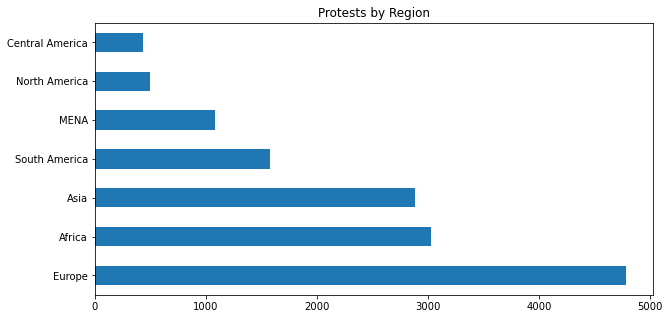

In [12]:
df['region'].value_counts().head(10).plot(kind='barh',figsize=(10 , 5),
                                           title='Protests by Region')

---
---
# Modelling

Objective:  Optimize the model selection through gridsearch. Then append dataframe results.

---
---

In [11]:
possible_responses = ['y_accomodation', 'y_arrests', 'y_beatings', 'y_crowd_dispersal', 'y_ignore', 'y_killings', 'y_shootings']

region_list = dict(df["region"].value_counts()).keys()

country_list = dict(df["country"].value_counts()).keys()

all_features = ['year', 'protesterviolence', 'participants', 'protest_length',
       'demand_labor_wage_dispute', 'demand_land_farm_issue',
       'demand_police_brutality', 'demand_political_behavior_or_process',
       'demand_price_hike_or_tax_policy', 'demand_removal_of_politician',
       'demand_social_restrictions', 'notes']

num_features = ['year', 'protesterviolence', 'participants', 'protest_length',
       'demand_labor_wage_dispute', 'demand_land_farm_issue',
       'demand_police_brutality', 'demand_political_behavior_or_process',
       'demand_price_hike_or_tax_policy', 'demand_removal_of_politician',
       'demand_social_restrictions']

---
### Logistic Regression

In [12]:
def logreg__protest_by_the_response(df, response):    
    X = df[all_features]
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    
    get_numeric_data = FunctionTransformer(lambda df: df[num_features], validate=False)
    get_text_data = FunctionTransformer(lambda df: df['notes'], validate=False)
    
    
    pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words='english'))
            ]))
         ])),
    ('log', LogisticRegression(max_iter=5000))
    ])
    
    params = {
        'log__penalty' : ['l2', 'l1'],
#        'log__C' : [0.001, 0.01, 0,1, 1, 5],
#        'features__text_features__cvec__max_df': [0.90, 0.95],
#        'features__text_features__cvec__max_features': [None, 1000, 3000, 5000],
        'log__solver' : ['liblinear']
    }
    

    gs = GridSearchCV(pipe, param_grid=params, cv=5, verbose=0)
    gs.fit(X_train, y_train)

    baseline = max([df[response].mean(), 1-df[response].mean()])
    
    reg_response_dict = {
        "model_type": "logreg",
        "region": df["region"].iloc[0],
        "training_score": gs.score(X_train, y_train),
        "testing_score": gs.score(X_test, y_test),
        "baseline": baseline,
        "baseline_response": (response[2:] if df[response].mean() > 0.5 else f"no {response[2:]}"),
        "model_success": ("yes" if gs.score(X_test, y_test) > (0.05+baseline) else "no"),
        "best_params": gs.best_params_
    }
    
    return reg_response_dict

---
### Random Forest

In [13]:
def rf__protest_by_the_response(df, response):
    X = df[all_features]
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    
    get_numeric_data = FunctionTransformer(lambda df: df[num_features], validate=False)
    get_text_data = FunctionTransformer(lambda df: df['notes'], validate=False)
    
    
    pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words='english'))
            ]))
         ])),
    ('rf', RandomForestClassifier())
    ])
    
    params = {
#        'rf__ccp_alpha' : [0.001, 0.01, 0.1, 1, 5],
        'rf__n_estimators' : [100, 300],
        'rf__max_depth' : [None, 5, 10],
        'rf__min_samples_split' : [2, 4],
        'rf__min_samples_leaf' : [1, 3]
    }
    
    gs = GridSearchCV(pipe, param_grid=params, cv=5, verbose=0)
    gs.fit(X_train, y_train)

    baseline = max([df[response].mean(), 1-df[response].mean()])
            
    reg_response_dict = {
        "model_type": "rf",
        "region": df["region"].iloc[0],
        "training_score": gs.score(X_train, y_train),
        "testing_score": gs.score(X_test, y_test),
        "baseline": baseline,
        "baseline_response": (response[2:] if df[response].mean() > 0.5 else f"no {response[2:]}"),
        "model_success": ("yes" if gs.score(X_test, y_test) > (0.05+baseline) else "no"),
        "best_params": gs.best_params_
    }
    
    return reg_response_dict

---
### SVC

In [14]:
def svc__protest_by_the_response(df, response):
    X = df[all_features]
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    
    get_numeric_data = FunctionTransformer(lambda df: df[num_features], validate=False)
    get_text_data = FunctionTransformer(lambda df: df['notes'], validate=False)
    
    
    pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words='english'))
            ]))
         ])),
    ('svc', SVC())
    ])
    
    params = {
        'svc__C' : [5],
        'svc__degree' :[2],
    }
    
    gs = GridSearchCV(pipe, param_grid=params, cv=5, verbose=0)
    gs.fit(X_train, y_train)

    baseline = max([df[response].mean(), 1-df[response].mean()])
            
    reg_response_dict = {
        "model_type": "svc",
        "region": df["region"].iloc[0],
        "training_score": gs.score(X_train, y_train),
        "testing_score": gs.score(X_test, y_test),
        "baseline": baseline,
        "baseline_response": (response[2:] if df[response].mean() > 0.5 else f"no {response[2:]}"),
        "model_success": ("yes" if gs.score(X_test, y_test) > (0.05+baseline) else "no"),
        "best_params": gs.best_params_
    }
    
    return reg_response_dict

---
### XGB Classifier

In [15]:
def xgb__protest_by_the_response(df, response):
    X = df[all_features]
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    
    get_numeric_data = FunctionTransformer(lambda df: df[num_features], validate=False)
    get_text_data = FunctionTransformer(lambda df: df['notes'], validate=False)
    
    
    pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words='english'))
            ]))
         ])),
    ('xg', XGBClassifier())
    ])
    
    params = {
#        'xg__gamma' : [0.001, 0.01, 0.1, 1, 5],
        'xg__max_depth' :[None, 2, 3],
#        'xg__learning_rate' : [0.001, 0.01, 0.1, 1, 5]
    }
    
    gs = GridSearchCV(pipe, param_grid=params, cv=5, verbose=0)
    gs.fit(X_train, y_train)

    baseline = max([df[response].mean(), 1-df[response].mean()])
            
    reg_response_dict = {
        "model_type": "xgb",
        "region": df["region"].iloc[0],
        "training_score": gs.score(X_train, y_train),
        "testing_score": gs.score(X_test, y_test),
        "baseline": baseline,
        "baseline_response": (response[2:] if df[response].mean() > 0.5 else f"no {response[2:]}"),
        "model_success": ("yes" if gs.score(X_test, y_test) > (0.05+baseline) else "no"),
        "best_params": gs.best_params_
    }
    
    return reg_response_dict

---
### Remaining functions

In [16]:
grid_results = pd.DataFrame(columns=["model_type", "region", "baseline_response", "training_score", "testing_score", "baseline", "model_success", "best_params"])



def logreg__responses_by_location(loc_df):
    return [logreg__protest_by_the_response(loc_df, response) for response in possible_responses]

def rf__responses_by_location(loc_df):
    return [rf__protest_by_the_response(loc_df, response) for response in possible_responses]

def svc__responses_by_location(loc_df):
    return [svc__protest_by_the_response(loc_df, response) for response in possible_responses]

def xgb__responses_by_location(loc_df):
    return [xgb__protest_by_the_response(loc_df, response) for response in possible_responses]

In [17]:
def df_by_region(df, region):
    return df[df["region"]==region]

def df_by_country(df, country):
    return df[df["country"]==country]

---
---
# Running the models
---
---

In [18]:
for region in region_list:
    for dct in logreg__responses_by_location(df_by_region(df, region)):
        grid_results = grid_results.append(dct, ignore_index=True)

C:\Users\Burger\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Burger\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Burger\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Burger\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\U

In [19]:
for region in region_list:
    for dct in rf__responses_by_location(df_by_region(df, region)):
        grid_results = grid_results.append(dct, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
for region in region_list:
    for dct in svc__responses_by_location(df_by_region(df, region)):
        grid_results = grid_results.append(dct, ignore_index=True)

In [ ]:
for region in region_list:
    for dct in xgb__responses_by_location(df_by_region(df, region)):
        grid_results = grid_results.append(dct, ignore_index=True)

---

In [ ]:
grid_results

In [ ]:
#grid_results.to_csv("./data/four_models.csv")

---
---
## Engineering & Assessment
---
---

In [ ]:
grid_results["success_rate"] = grid_results["testing_score"] - grid_results["baseline"]

In [ ]:
lg = grid_results[grid_results["model_type"] == "logreg"]["success_rate"].mean()
rf = grid_results[grid_results["model_type"] == "rf"]["success_rate"].mean()
svc = grid_results[grid_results["model_type"] == "svc"]["success_rate"].mean()
xgb = grid_results[grid_results["model_type"] == "xgb"]["success_rate"].mean()

In [ ]:
print(f"Logistic Regression:\t{lg}")
print(f"Random Forest:\t\t{rf}")
print(f"SVC:\t\t\t{svc}")
print(f"XGB Classifier:\t\t{xgb}")

---
---
# Additional Modelling
---
---
Consolidating the possible protest outcomes into broader, more predictable categories

In [ ]:
new_drops = ['y_arrests', 'y_crowd_dispersal', 'y_beatings', 'y_killings', 'y_shootings']

df["y_adverse_reaction"] = df["y_arrests"] + df["y_crowd_dispersal"]
df["y_adverse_reaction"] = df["y_adverse_reaction"].map(lambda x: 1 if x>0 else 0)

df["y_state_violence"] = df["y_beatings"] + df["y_killings"] + df["y_shootings"]
df["y_state_violence"] = df["y_state_violence"].map(lambda x: 1 if x>0 else 0)

df.drop(columns=new_drops, inplace=True)

In [ ]:
possible_responses = ['y_accomodation', 'y_ignore', 'y_adverse_reaction', 'y_state_violence']
possible_demands = ['demand_labor_wage_dispute', 'demand_land_farm_issue',
       'demand_police_brutality', 'demand_political_behavior_or_process',
       'demand_price_hike_or_tax_policy', 'demand_removal_of_politician',
       'demand_social_restrictions']

for r in possible_responses:
    df[r] = df[r].map(lambda x: 1 if x>0 else 0)
    
for d in possible_demands:
    df[d] = df[d].map(lambda x: 1 if x>0 else 0)

In [ ]:
df.columns

In [ ]:
possible_responses = ['y_accomodation', 'y_ignore', 'y_adverse_reaction', 'y_state_violence']

def xgb__protest_by_the_response(df, response):
    xgb_features = all_features + ["country", "protesteridentity", "sources"]
    text_features = ["country", "protesteridentity", "sources", "notes"]
    
    X = df[xgb_features]
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    
    get_numeric_data = FunctionTransformer(lambda df: df[num_features], validate=False)
    get_text_data = FunctionTransformer(lambda df: df[text_features], validate=False)
    
    
    pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words='english'))
            ]))
         ])),
    ('xg', XGBClassifier())
    ])
    
    params = {
#        'xg__gamma' : [0.001, 0.01, 0.1, 1, 5],
        'xg__max_depth' :[2],
#        'xg__learning_rate' : [0.001, 0.01, 0.1, 1, 5]
    }
    
    gs = GridSearchCV(pipe, param_grid=params, cv=5, verbose=0)
    gs.fit(X_train, y_train)

    baseline = max([df[response].mean(), 1-df[response].mean()])
            
    reg_response_dict = {
        "model_type": "xgb",
        "region": df["region"].iloc[0],
        "training_score": gs.score(X_train, y_train),
        "testing_score": gs.score(X_test, y_test),
        "baseline": baseline,
        "baseline_response": (response[2:] if df[response].mean() > 0.5 else f"no {response[2:]}"),
        "model_success": ("yes" if gs.score(X_test, y_test) > (0.05+baseline) else "no"),
        "best_params": gs.best_params_
    }
    
    return reg_response_dict

In [ ]:
def xgb__protest_by_the_response(df, response):
    X = df[all_features]
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    
    get_numeric_data = FunctionTransformer(lambda df: df[num_features], validate=False)
    get_text_data = FunctionTransformer(lambda df: df['notes'], validate=False)
    
    
    pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words='english'))
            ]))
         ])),
    ('xg', XGBClassifier())
    ])
    
    params = {
#        'xg__gamma' : [0.001, 0.01, 0.1, 1, 5],
        'xg__max_depth' :[2],
#        'xg__learning_rate' : [0.001, 0.01, 0.1, 1, 5]
    }
    
    gs = GridSearchCV(pipe, param_grid=params, cv=5, verbose=0)
    gs.fit(X_train, y_train)

    baseline = max([df[response].mean(), 1-df[response].mean()])
            
    reg_response_dict = {
        "model_type": "xgb",
        "region": df["region"].iloc[0],
        "training_score": gs.score(X_train, y_train),
        "testing_score": gs.score(X_test, y_test),
        "baseline": baseline,
        "baseline_response": (response[2:] if df[response].mean() > 0.5 else f"no {response[2:]}"),
        "model_success": ("yes" if gs.score(X_test, y_test) > (0.05+baseline) else "no"),
    }
    
    return reg_response_dict

In [ ]:
def xgb__responses_by_location(loc_df):
    return [xgb__protest_by_the_response(loc_df, response) for response in possible_responses]

def df_by_region(df, region):
    return df[df["region"]==region]

In [ ]:
xgb_results = pd.DataFrame(columns=["model_type", "region", "baseline_response", "training_score", "testing_score", "baseline", "model_success"])




for region in region_list:
    for dct in xgb__responses_by_location(df_by_region(df, region)):
        xgb_results = xgb_results.append(dct, ignore_index=True)

In [ ]:
xgb_results

In [ ]:
xgb_results["success_rate"] = xgb_results["testing_score"] - xgb_results["baseline"]

xgb_success = xgb_results[xgb_results["baseline"]<0.85]["success_rate"].mean()
print(f"XGB Success Rate for baselines under 85%:\t{xgb_success}")

In [3]:
import matplotlib.pyplot as plt

In [4]:
plt.plot('x', 'y', data=df, marker='o', alpha=0.4)

NameError: name 'df' is not defined